This notebook takes borehole data from the East Kimberley and depth to base of cenozoic interporetations and finds what the key data for predicting them may be

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [8]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon
import pandas as pd
import fiona
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

In [91]:
def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None

# Function for assigning stratigraphy above and below a point
# for a given downhole log/ layered model
def assign_stratigraphy_from_depth(df, depth, depth_columns, labels = ['cenozoic', 'mixed_signal', 'basement']):
    
    df['stratigraphy'] = ''
    
    if depth_columns == ['Depth']:
        
        for index, row in df.iterrows():
            if row['Depth'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif row['Depth'] == depth:
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df
    
    elif depth_columns == ['Depth_from', 'Depth_to']:
        for index, row in df.iterrows():
            if row['Depth_to'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif (row['Depth_from'] < depth) & (row['Depth_to'] > depth):
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth_from'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df


In [11]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()


In [79]:
# No lets import the interpreted depths

# Bring in the interpreted depth to the base of the ceonozoic
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\base_of_cenozoic_picked.csv"

df_interp = pd.read_csv(infile)

# Now join the coordinates onto the new dataframe

df_interp = df_interp.merge(df_header, on = 'borehole_id')

df_interp = df_interp[['borehole_id','base_of_cenozoic_depth','base_of_ceno_elevation','Easting', 'Northing']]

enos = df_interp['borehole_id'].unique()

In [80]:
df_header = borehole_utils.extract_sql_with_primary_key("borehole", ['*'], connection, enos,
                                                verbose = True)

select t.* from borehole t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635746);


In [81]:
df_header

,borehole_id,Borehole_name,Alternative_name,Easting,Northing,Ground_elevation_mAHD,Induction_acquired,Gamma_acquired,Javelin_acquired,Hylogger_acquired_on_core,Hylogger_acquired_on_chips,Lithology_available,EC_pH_acquired,SWL_available,Construction_available,MagSus_available,AEM_conductivity_available,geometry,geom
0,635728,RN040873,KR08,520144.760,8306293.880,7.519,1,1,1,1,0,1,1,1,1,1,1,POINT (520144.76 8306293.88),b'\x00\x01\xc0n\x00\x00\xa4p=\nC\xbf\x1fA\x85\...
1,635730,RN040880,KR22a,523640.009,8316422.357,4.364,1,1,1,1,0,1,1,1,1,1,1,POINT (523640.009 8316422.357),b'\x00\x01\xc0n\x00\x00\xc7K7\t\xe0\xf5\x1fA\x...
2,635733,RN040874,KR30,501830.614,8295403.070,17.506,1,1,1,1,0,1,1,1,1,1,1,POINT (501830.614 8295403.07),b'\x00\x01\xc0n\x00\x00\x7fj\xbct\x1a\xa1\x1eA...
3,635734,RN040877,KR31,504915.931,8292360.686,17.913,1,0,1,1,0,1,1,1,1,1,1,POINT (504915.931 8292360.686),b'\x00\x01\xc0n\x00\x00b\x10X\xb9O\xd1\x1eA\x8...
4,635735,RN040878,KR33,505309.448,8293856.701,16.494,1,1,1,1,0,1,1,1,1,1,1,POINT (505309.448 8293856.701),b'\x00\x01\xc0n\x00\x00\x12\x83\xc0\xcau\xd7\x...
5,635737,RN040884,KR38,507769.229,8299897.749,12.462,1,1,1,1,0,1,1,1,1,1,1,POINT (507769.229 8299897.749),b'\x00\x01\xc0n\x00\x00\xdb\xf9~\xea\xe4\xfd\x...
6,635738,RN040883,KR40,514309.962,8298828.237,17.673,1,1,1,1,0,1,1,1,1,1,1,POINT (514309.962 8298828.237),b'\x00\x01\xc0n\x00\x00+\x87\x16\xd9\x17d\x1fA...
7,635739,RN040881,KR45,500051.985,8295681.132,18.799,1,1,1,1,0,1,1,1,1,1,1,POINT (500051.985 8295681.132),b'\x00\x01\xc0n\x00\x00\n\xd7\xa3\xf0O\x85\x1e...
8,635740,RN040882,KR46,500053.109,8296644.456,18.357,1,1,1,1,0,1,1,1,1,1,1,POINT (500053.109 8296644.456),b'\x00\x01\xc0n\x00\x00-\xb2\x9doT\x85\x1eA\xa...
9,635741,RN040876,KR48,500049.774,8295302.212,19.046,1,1,1,1,0,1,1,1,1,1,1,POINT (500049.774 8295302.212),b'\x00\x01\xc0n\x00\x00\xbct\x93\x18G\x85\x1eA...


utm_zone = 52
14 points in UTM bounding box: [500049.774, 8292360.686, 542730.465, 8331303.544]


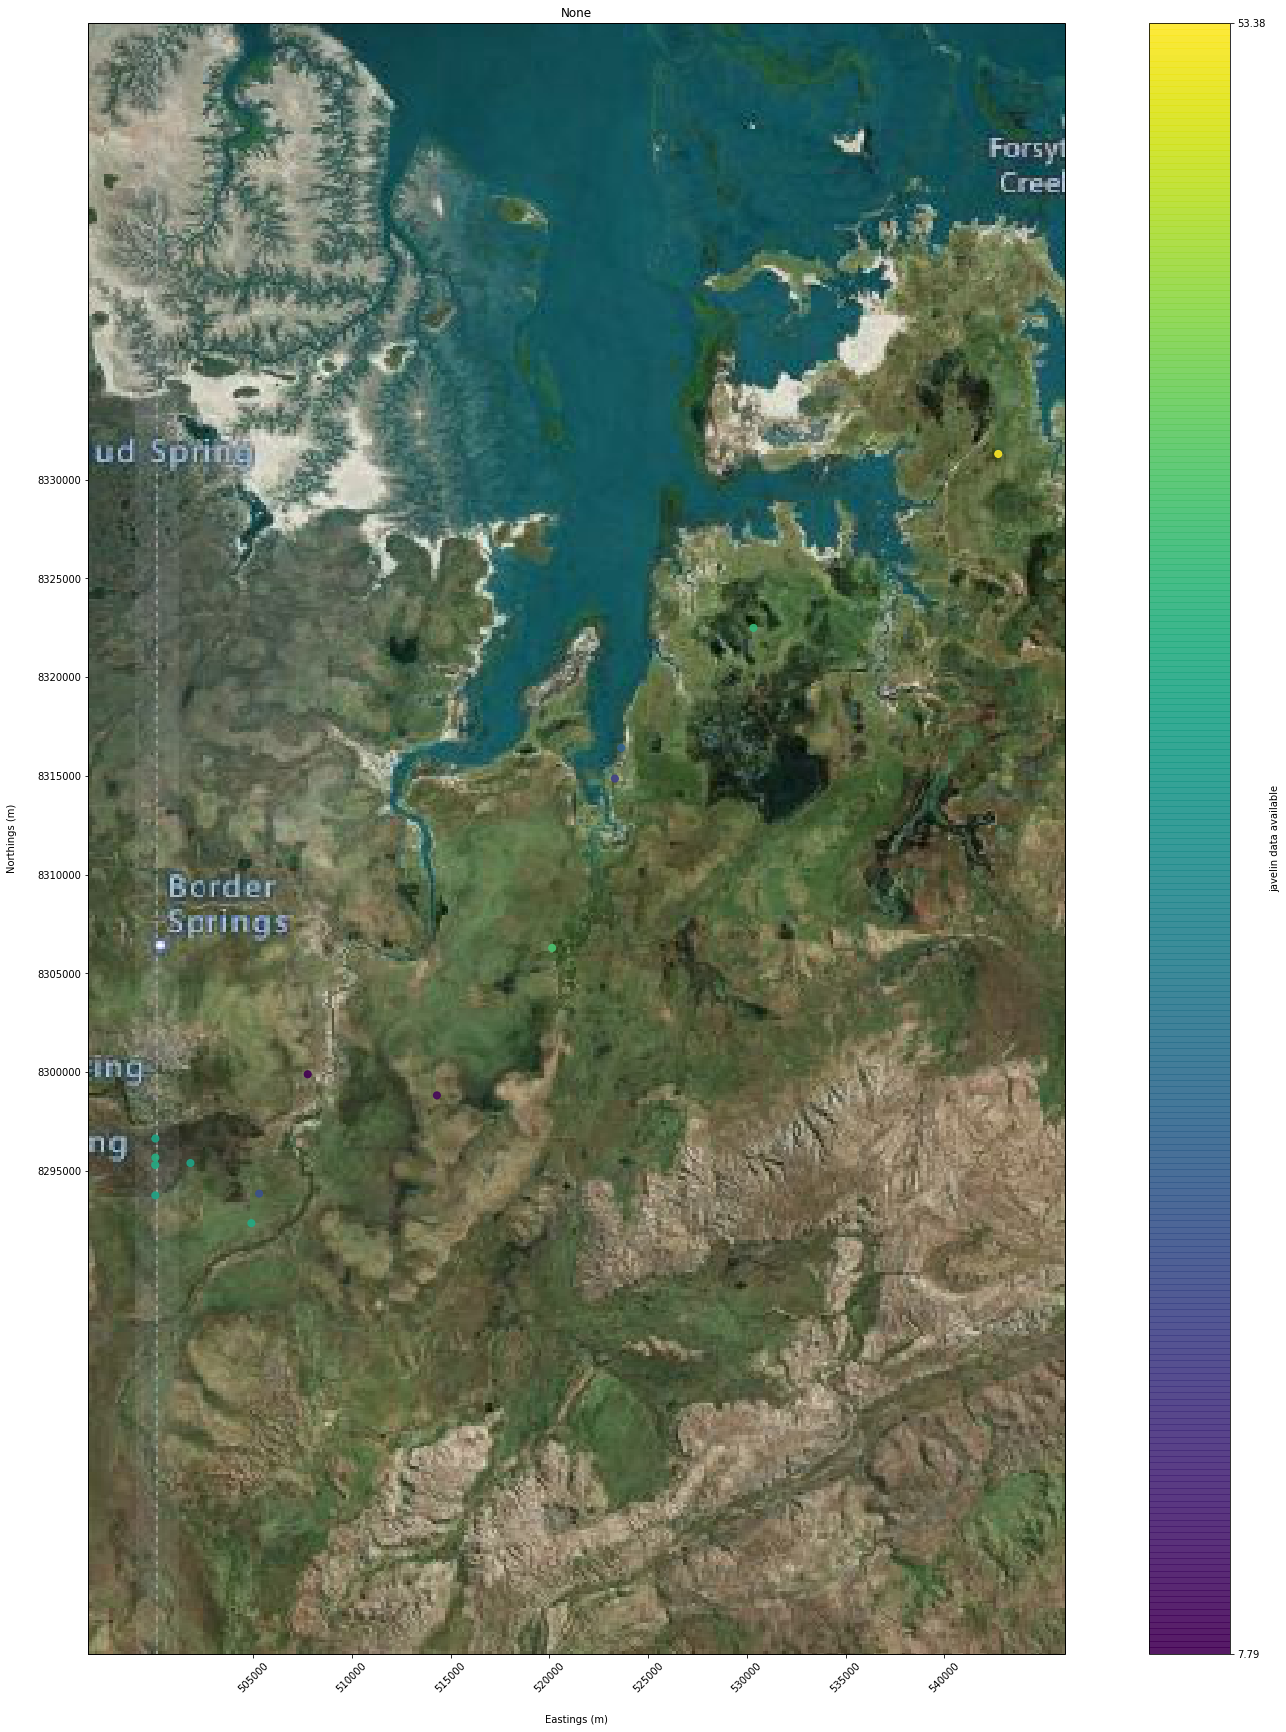

In [82]:
# Plot the bores on a basemap to get an idea of what datasets are available

utm_coords = df_interp[['Easting', 'Northing']].values

# For example do we have javelin available
depth = df_interp['base_of_cenozoic_depth'].values

plotting_utils.plot_point_dataset(utm_coords, "EPSG:28352", depth,
                   colourbar_label = 'javelin data available', colour_scheme = 'viridis',
                    point_size=50)


In [83]:
# First import all the datasets based on our enos (primary key)


df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", ['Depth', 'Total_water_content',
                                                'Clay_water_content', 'Capillary_water_content',
                                               'Free_water_content', 'K_SDR', 'borehole_id'], connection, enos,
                                                verbose = True)

df_lithology = borehole_utils.extract_sql_with_primary_key("borehole_lithology", ['Depth_from', 'Depth_to',
                                                'Lithology_name', 'Munsell_colour',
                                                           'borehole_id'], connection, enos,
                                                          verbose = True)


# Classify the lithology using a yaml file keyword lookup table
yaml_file = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\classification\hydclass_classification.yml"

with open(yaml_file) as f:
    # use safe_load instead load
    hyd_class = yaml.safe_load(f)


# Assign all rows to a class of 7 which is the unkown class
df_lithology['hydraulic_class'] = 7

# iterate through lithology names
for index, row in df_lithology.iterrows():
    lithname = row.Lithology_name
    
    # Add the classification integer to the dataframe if it is found
    interval_class = search(hyd_class, lithname)
    
    if interval_class is not None:
        df_lithology.at[index, 'hydraulic_class'] = interval_class
    else:
        # Otherwise we can add it to the yaml file
        print(lithname)
    
    

df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','Gamma_calibrated',
                                                         'GR','borehole_id'], connection, enos,
                                                       verbose = True)

df_EC_pH = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'pH', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_AEM = borehole_utils.extract_sql_with_primary_key("representative_AEM_bulk_conductivity", 
                                                       ['Depth_from', 'Depth_to', 'Bulk_conductivity', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_magsus = borehole_utils.extract_sql_with_primary_key("magnetic_susceptibility", 
                                                       ['Depth', 'Magnetic_susceptibility', 'borehole_id'],
                                                       connection, enos, verbose = True)

select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.K_SDR, t.borehole_id from boreholeNMR_data t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635746);
select t.Depth_from, t.Depth_to, t.Lithology_name, t.Munsell_colour, t.borehole_id from borehole_lithology t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635746);
select t.Depth, t.Apparent_conductivity, t.Gamma_calibrated, t.GR, t.borehole_id from induction_gamma_data t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635746);
select t.Depth, t.EC, t.pH, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635746);
select t.Depth_from, t.Depth_to, t.Bulk_conductivity, t.borehol

In [84]:
# Define our columns of interest for the hylogging data

columns = ["Quartz_(U_TIR_TSA707_Mineral)",
          "Kaolinite-PX_(U_SWIR_TSA705_Mineral)",
          "Kaolinite-WX_(U_SWIR_TSA705_Mineral)",
          "Kaolinite-PX_(U_TIR_TSA707_Mineral)",
          "Kaolinite-WX_(U_TIR_TSA707_Mineral)",
          "Calcite_(U_SWIR_TSA705_Mineral)",
          "Montmorillonite_(U_TIR_TSA707_Mineral)",
          "Montmorillonite_(U_SWIR_TSA705_Mineral)",
           "Depth", "borehole_id"
          ]

In [85]:
# Import the hylogging data

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\hylogger\EK_hylogg_results_chips.csv"

df_chips = pd.read_csv(infile)[columns]

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\hylogger\EK_hylogg_results_core.csv"

df_core = pd.read_csv(infile)[columns]


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
# Stack the data

df_hylog = df_chips.append(df_core)

In [87]:
# Now for the important datasets lets assign them as either cenozoic, basement
# or a mixture

df_AEM['stratigraphy'] = ''

for index, row in df_interp.iterrows():
    borehole = int(row['borehole_id'])
    
    depth = row['base_of_cenozoic_depth']
    
    # AEM
    
    mask = df_AEM['borehole_id'] == borehole
    
    df_AEM_ = assign_stratigraphy_from_depth(df_AEM[mask], depth, ['Depth_from', 'Depth_to'])
    
    df_AEM.at[df_AEM[mask].index, 'stratigraphy'] = df_AEM_
    
    

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
df_AEM_shallow = df_AEM[df_AEM['Depth_from'] < 50.]

In [93]:
# Create a sub plot with the various histograms

fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize = (4,6), sharex = True)

masks =  ['cenozoic', 'mixed_signal', 'basement']

# Assign row and column for the subpots

ax1.hist(np.log10(df_AEM_shallow[df_AEM_shallow['stratigraphy'] == masks[0]].values),
         bins = 30)
ax2.hist(np.log10(df_AEM_shallow[df_AEM_shallow['stratigraphy'] == masks[1]].values),
         bins = 30)
ax3.hist(np.log10(df_AEM_shallow[df_AEM_shallow['stratigraphy'] == masks[1]].values,
                  bins = 30)
ax1.set_title('cenozoic bulk log conductivity')
ax2.set_title('tranisition bulk log  conductivity')
ax3.set_title('tranisition bulk log  conductivity')
         
#fig.tight_layout()
#fig.delaxes(axs[3,1])
#plt.savefig(r'C:\Users\symin\Documents\GA\aquifer_properties\results\OB_histograms_subplots.png')
plt.show()

,Depth_from,Depth_to,Bulk_conductivity,borehole_id,stratigraphy
0,0.00,2.00,0.160000,635728,cenozoic
1,2.00,4.30,0.228154,635728,cenozoic
2,4.30,6.80,0.369549,635728,cenozoic
3,6.80,9.70,0.903342,635728,cenozoic
4,9.70,12.90,0.878735,635728,cenozoic
5,12.90,16.60,0.483092,635728,cenozoic
6,16.60,20.70,0.470367,635728,cenozoic
7,20.70,25.40,0.774593,635728,cenozoic
8,25.40,30.60,1.011122,635728,cenozoic
9,30.60,36.50,0.734754,635728,cenozoic
